Downloading the required libraries

In [3]:
!pip install nltk googletrans==4.0.0-rc1
!pip install transformers torch ipywidgets
!pip install optuna
!pip install transformers

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=36c0e429c8a11202bc2b2da8bc08da6fc1945d6f9bc4b1c702afffba5c188892
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
     

Importing the required libraries

In [4]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import random
from nltk.corpus import wordnet
from googletrans import Translator
import torch
import torch.nn as nn
import re
from nltk.corpus import stopwords
import nltk
import string
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import optuna
from transformers import TrainerCallback

In [ ]:
import nltk
nltk.download('wordnet')

As i was working on kaggle environment, this part is crucial to unzip the nltk files 

In [6]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Importing NLTK libraries

In [10]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Loading the dataset

In [11]:
dataset = load_dataset("SetFit/sst5")
print("Dataset Structure:", dataset)

README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Dataset Structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})


In [12]:
print("Unique labels in train:", set(dataset["train"]["label"]))
print("Unique labels in validation:", set(dataset["validation"]["label"]))
print("Unique labels in test:", set(dataset["test"]["label"]))

Unique labels in train: {0, 1, 2, 3, 4}
Unique labels in validation: {0, 1, 2, 3, 4}
Unique labels in test: {0, 1, 2, 3, 4}


import wandb to watch the runs

In [ ]:
import wandb
wandb.init()

Tokenization

In [13]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Fix_apostrophes function, especially cases like won't and wo n't

In [14]:
def fix_apostrophes(text):
    contractions = {
        "wo n't": "won't",
        "ca n't": "can't",
        "n't": "n't",  
        " 's": "'s",
        " 't": "'t",
        " 're": "'re",
        " 've": "'ve",
        " 'll": "'ll",
        " 'd": "'d",
    }

    for key, value in contractions.items():
        text = text.replace(key, value)

    text = re.sub(r"wo n't", "won't", text)

    return text

Function to remove punctuation

In [15]:
def remove_punctuation(text):
    return "".join([char for char in text if char not in string.punctuation])

In [16]:
def preprocess_text(text):
    text = fix_apostrophes(text)    
    text = remove_punctuation(text)
    tokens = tokenizer.tokenize(text.lower()) 
    return tokens

Apply the above preprocessing techniques into our train,validation,test dataset
and give an example of tokenization

In [22]:
def fix_apostrophes_in_tokens(tokens):
    fixed_tokens = []
    for token in tokens:
        # Apply contraction fixes to each token
        token = token.replace(" 's", "'s")
        token = token.replace(" 't", "'t")
        token = token.replace(" 're", "'re")
        token = token.replace(" 've", "'ve")
        token = token.replace(" 'll", "'ll")
        token = token.replace(" 'd", "'d")
        fixed_tokens.append(token)
    return fixed_tokens

def preprocess_function(examples):
    tokens = examples["text"]
    
    # Fix apostrophes in each token (after tokenization)
    tokens = fix_apostrophes_in_tokens(tokens)
    
    # Tokenize using ALBERT tokenizer
    return tokenizer(tokens, padding="max_length", truncation=True, max_length=64)

# Apply preprocessing to the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)


# Apply preprocessing to the dataset
for split in ['train', 'validation', 'test']:
    dataset[split] = dataset[split].map(lambda x: {"text": preprocess_text(x["text"])})

for i in range(3):
    print(f"Sample {i + 1} preprocessed tokens: {dataset['train'][i]['text']}\n")


# Check the first few processed samples after encoding
for i in range(3):
    print(f"Sample {i + 1} encoded tokens: {encoded_dataset['train'][i]}")

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

Sample 1 preprocessed tokens: ['▁a', '▁stirring', '▁funny', '▁and', '▁finally', '▁transporting', '▁rei', 'magi', 'ning', '▁of', '▁beauty', '▁and', '▁the', '▁beast', '▁and', '▁1930', 's', '▁horror', '▁films']

Sample 2 preprocessed tokens: ['▁apparently', '▁re', 'assemble', 'd', '▁from', '▁the', '▁cutting', 'room', '▁floor', '▁of', '▁any', '▁given', '▁daytime', '▁soap']

Sample 3 preprocessed tokens: ['▁they', '▁presume', '▁their', '▁audience', '▁wont', '▁sit', '▁still', '▁for', '▁a', '▁sociology', '▁lesson', '▁however', '▁entertaining', 'ly', '▁presented', '▁so', '▁they', '▁trot', '▁out', '▁the', '▁conventional', '▁science', 'fiction', '▁elements', '▁of', '▁bug', 'eyed', '▁monsters', '▁and', '▁futuristic', '▁women', '▁in', '▁ski', 'mp', 'y', '▁clothes']

Sample 1 encoded tokens: {'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4, 'label_text': 'very positive', 'input_ids': [2, 21, 20477, 13, 15, 5066, 17, 722, 

Declare the max-length

In [23]:
max_length = 64

Metrics function

In [24]:
def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="weighted")
    accuracy = accuracy_score(p.label_ids, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [56]:
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=5)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,  # Training for 20 epochs
    per_device_train_batch_size=32,  # Batch size from hyperparameter tuning
    per_device_eval_batch_size=64,  # Typically 2x train batch size for evaluation
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    save_strategy="epoch",  # Save model at the end of every epoch
    learning_rate=2.3532960037330013e-05,  # Learning rate from hyperparameter tuning
    load_best_model_at_end=True,  # Load best model at the end of training
    logging_dir="./logs",  # Directory for logs
    logging_steps=100,  # Log every 100 steps
    fp16=True,  # Use mixed precision training
    save_total_limit=2,  # Save only the 2 most recent checkpoints
    dataloader_num_workers=4,  # Number of data loading threads
    report_to=None,  # Disable reporting to external trackers like WandB
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# Train and Evaluate
trainer.train()
results = trainer.evaluate()

# Print Results
print("Evaluation Results:", results)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.075500,1.303996,0.455949,0.482580,0.455949,0.399905


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

KeyboardInterrupt: 

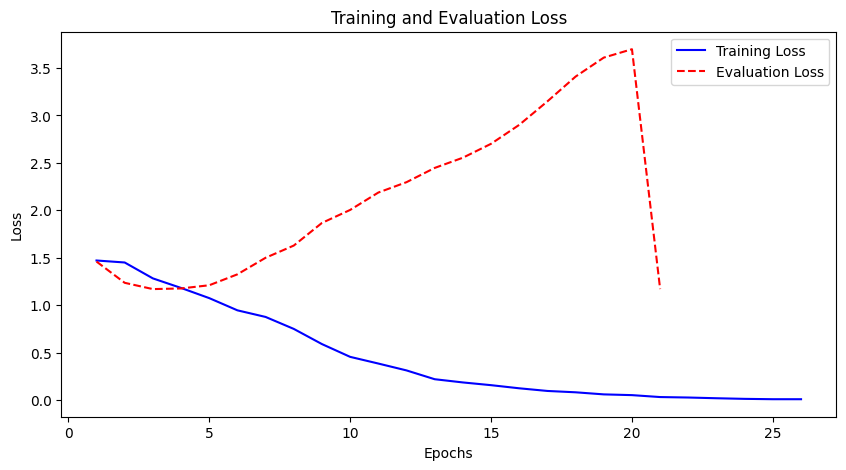

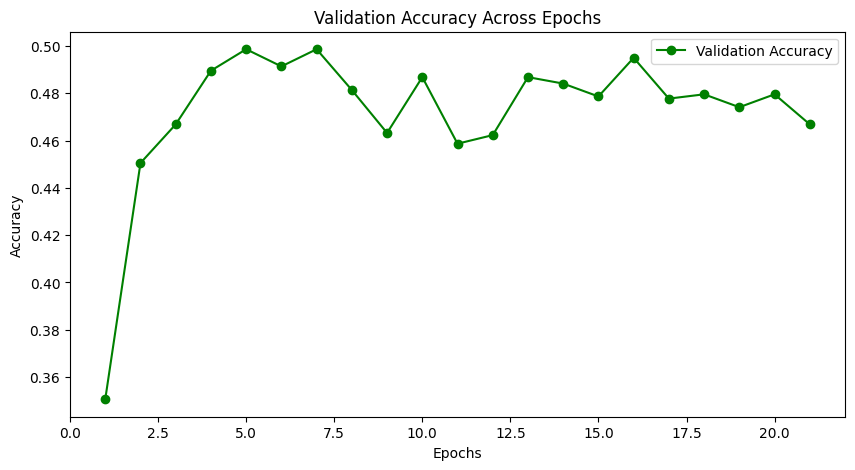

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 

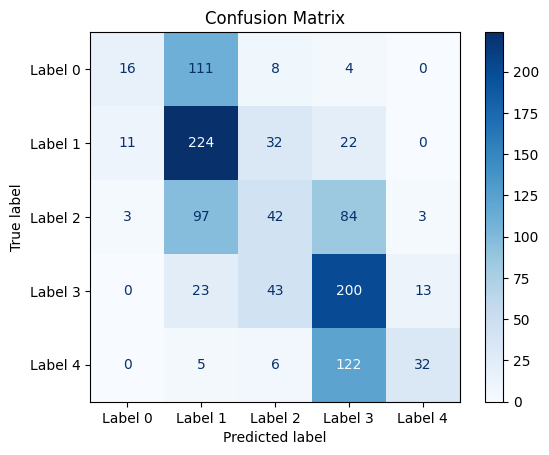

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Access training history
metrics = trainer.state.log_history

# Extract training loss and evaluation accuracy per epoch
train_loss = [x['loss'] for x in metrics if 'loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in metrics if 'eval_accuracy' in x]
eval_loss = [x['eval_loss'] for x in metrics if 'eval_loss' in x]
epochs = range(1, len(eval_accuracy) + 1)

# Plot Loss over Time (Training and Evaluation Loss)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(epochs, eval_loss, label='Evaluation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

# Plot Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Epochs')
plt.legend()
plt.show()

# Make predictions on the validation dataset to generate the confusion matrix
predictions = trainer.predict(encoded_dataset["validation"])

# Extract predicted labels and true labels
preds = predictions.predictions.argmax(axis=1)  # Get predicted class
labels = predictions.label_ids  # True labels

# Generate confusion matrix
cm = confusion_matrix(labels, preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Label 0", "Label 1", "Label 2", "Label 3", "Label 4"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


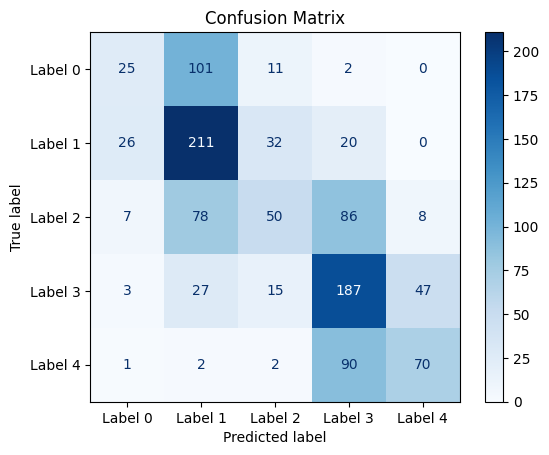

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the validation dataset
predictions = trainer.predict(encoded_dataset["validation"])

# Extract predicted labels and true labels
preds = predictions.predictions.argmax(axis=1)  # Get predicted class
labels = predictions.label_ids  # True labels

# Generate confusion matrix
cm = confusion_matrix(labels, preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Label 0", "Label 1", "Label 2", "Label 3", "Label 4"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [10]:
import wandb
wandb.init()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [30]:
class LRTrackerCallback(TrainerCallback):
    def __init__(self):
        self.lrs = []

    def on_step_begin(self, args, state, control, **kwargs):
        if state.global_step > 0:
            self.lrs.append(args.learning_rate)

In [26]:
import optuna
from transformers import AlbertForSequenceClassification, TrainingArguments, Trainer

def model_init():
    return AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=5)

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    # Update ALBERT model configuration for dropout
    model_config = model_init().config
    model_config.hidden_dropout_prob = dropout_rate
    model_config.attention_probs_dropout_prob = dropout_rate

    def custom_model_init():
        return AlbertForSequenceClassification(config=model_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,  # Fixed epochs for each trial
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        logging_dir="./logs",
        logging_steps=100,
        fp16=True,
        save_total_limit=2,
        dataloader_num_workers=4,
    )

    # Define Trainer
    trainer = Trainer(
        model_init=custom_model_init,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate and return F1 score for tuning
    eval_results = trainer.evaluate()
    return eval_results["eval_f1"]

# Run Hyperparameter Tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Adjust number of trials if needed

# Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train Final Model with Best Parameters
best_training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,  # Fixed epochs for final model as well
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"] * 2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"],
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    save_total_limit=2,
    dataloader_num_workers=4,
)

final_trainer = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train and evaluate the final model
final_trainer.train()
test_results = final_trainer.evaluate(encoded_dataset["test"])
print("Test Results:", test_results)


[I 2024-12-15 07:39:45,938] A new study created in memory with name: no-name-3c62d292-6351-41c7-8066-837149c4946c
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/2615913183.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.583068,0.262489,0.068900,0.262489,0.109150
2,1.582800,1.582953,0.253406,0.064215,0.253406,0.102464
3,1.576800,1.571039,0.262489,0.068900,0.262489,0.109150
4,1.576800,1.574931,0.253406,0.064215,0.253406,0.102464
5,1.572000,1.559560,0.283379,0.156022,0.283379,0.156791


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-12-15 07:44:52,815] Trial 0 finished with value: 0.1567906931155323 and parameters: {'learning_rate': 3.191799560499319e-05, 'batch_size': 64, 'weight_decay': 0.16011096233127764, 'dropout_rate': 0.1277767839177707}. Best is trial 0 with value: 0.1567906931155323.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weigh

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.588500,1.593662,0.253406,0.064215,0.253406,0.102464


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

KeyboardInterrupt: 

In [31]:
def model_init():
    return AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=5)

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        load_best_model_at_end=True,
        logging_dir="./logs",
        logging_steps=100,
        fp16=True,
        save_total_limit=2,
        dataloader_num_workers=4,
    )

    lr_tracker = LRTrackerCallback()

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[lr_tracker],
    )

    # Train the model
    trainer.train()

    # Evaluate and return f1 score for tuning
    eval_results = trainer.evaluate()
    trial.set_user_attr("lrs", lr_tracker.lrs)
    return eval_results["eval_f1"]

In [32]:
# Run Hyperparameter Tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train Final Model with Best Parameters
best_training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"] * 2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    save_total_limit=2,
    dataloader_num_workers=4,
)

final_lr_tracker = LRTrackerCallback()

final_trainer = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[final_lr_tracker],
)


[I 2024-12-15 07:46:38,632] A new study created in memory with name: no-name-21461a2b-5dd6-43a2-b9eb-a957f7a8444e
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weigh

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.421400,1.198034,0.450500,0.466970,0.450500,0.386266
2,1.149100,1.133578,0.499546,0.495821,0.499546,0.481055
3,0.888600,1.137129,0.520436,0.520695,0.520436,0.511572


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 07:49:34,039] Trial 0 finished with value: 0.4810547491220023 and parameters: {'learning_rate': 4.175563550168982e-05, 'batch_size': 32}. Best is trial 0 with value: 0.4810547491220023.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cla

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.202737,0.473206,0.430344,0.473206,0.392323
2,1.282600,1.142482,0.489555,0.495049,0.489555,0.432562
3,1.074700,1.120542,0.501362,0.504089,0.501362,0.460918


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 07:52:23,863] Trial 1 finished with value: 0.46091765809586005 and parameters: {'learning_rate': 1.7305475346313195e-05, 'batch_size': 64}. Best is trial 0 with value: 0.4810547491220023.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['c

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.170283,0.483197,0.432330,0.483197,0.410942
2,1.239900,1.170113,0.495005,0.496997,0.495005,0.460937
3,1.007200,1.098642,0.519528,0.517476,0.519528,0.501369


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 07:55:13,710] Trial 2 finished with value: 0.5013685506748804 and parameters: {'learning_rate': 2.5686992707646962e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cl

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.445176,0.363306,0.254920,0.363306,0.269433
2,1.501800,1.367669,0.398728,0.381146,0.398728,0.331655
3,1.168000,1.167353,0.475931,0.503580,0.475931,0.403737


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 07:58:02,873] Trial 3 finished with value: 0.4037370531353938 and parameters: {'learning_rate': 4.805563861842508e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cla

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.185535,0.485014,0.590499,0.485014,0.399643
2,1.263200,1.119923,0.500454,0.496017,0.500454,0.471059
3,1.013100,1.100786,0.508629,0.502954,0.508629,0.488983


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 08:00:52,341] Trial 4 finished with value: 0.4889826316508937 and parameters: {'learning_rate': 2.3114238237331124e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cl

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.326200,1.219185,0.465032,0.456948,0.465032,0.390929
2,1.117400,1.195486,0.489555,0.471119,0.489555,0.462942
3,1.464800,1.402378,0.401453,0.273919,0.401453,0.320299


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 08:03:47,655] Trial 5 finished with value: 0.46294200817794173 and parameters: {'learning_rate': 1.5561135777224535e-05, 'batch_size': 32}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['c

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.529500,1.336928,0.391462,0.367687,0.391462,0.284591
2,1.294000,1.178424,0.467757,0.454885,0.467757,0.410584
3,1.038200,1.150973,0.493188,0.484902,0.493188,0.475761


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 08:06:40,859] Trial 6 finished with value: 0.4757611838179599 and parameters: {'learning_rate': 4.214392613512261e-05, 'batch_size': 32}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cla

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.215981,0.487738,0.513496,0.487738,0.432420
2,1.264300,1.200976,0.496821,0.483466,0.496821,0.471648
3,0.998800,1.097475,0.517711,0.512620,0.517711,0.501050


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 08:09:30,201] Trial 7 finished with value: 0.5010496402794768 and parameters: {'learning_rate': 4.015258494573058e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cla

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.178900,1.108647,0.518619,0.537706,0.518619,0.471742
2,0.996300,1.101972,0.509537,0.499920,0.509537,0.492733
3,0.780000,1.123975,0.530427,0.526075,0.530427,0.522531


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 08:12:35,481] Trial 8 finished with value: 0.4927327571664055 and parameters: {'learning_rate': 2.365046014548392e-05, 'batch_size': 16}. Best is trial 2 with value: 0.5013685506748804.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/226668018.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['cla

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.331600,1.200976,0.481381,0.538518,0.481381,0.414966
2,1.100900,1.165306,0.485922,0.470067,0.485922,0.466085
3,0.931600,1.105187,0.520436,0.513828,0.520436,0.503737


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[I 2024-12-15 08:15:30,128] Trial 9 finished with value: 0.5037373120872792 and parameters: {'learning_rate': 2.3532960037330013e-05, 'batch_size': 32}. Best is trial 9 with value: 0.5037373120872792.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/2337379468.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


Best Hyperparameters: {'learning_rate': 2.3532960037330013e-05, 'batch_size': 32}


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


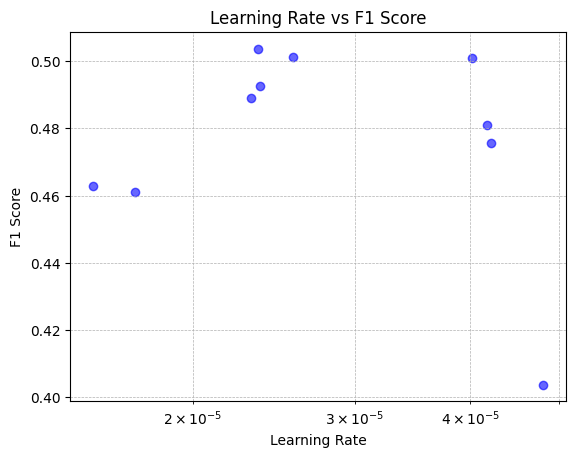

In [33]:
learning_rates = [trial.params["learning_rate"] for trial in study.trials]
f1_scores = [trial.value for trial in study.trials]

plt.figure()
plt.scatter(learning_rates, f1_scores, c='blue', alpha=0.6)
plt.xscale('log') 
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.title("Learning Rate vs F1 Score")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

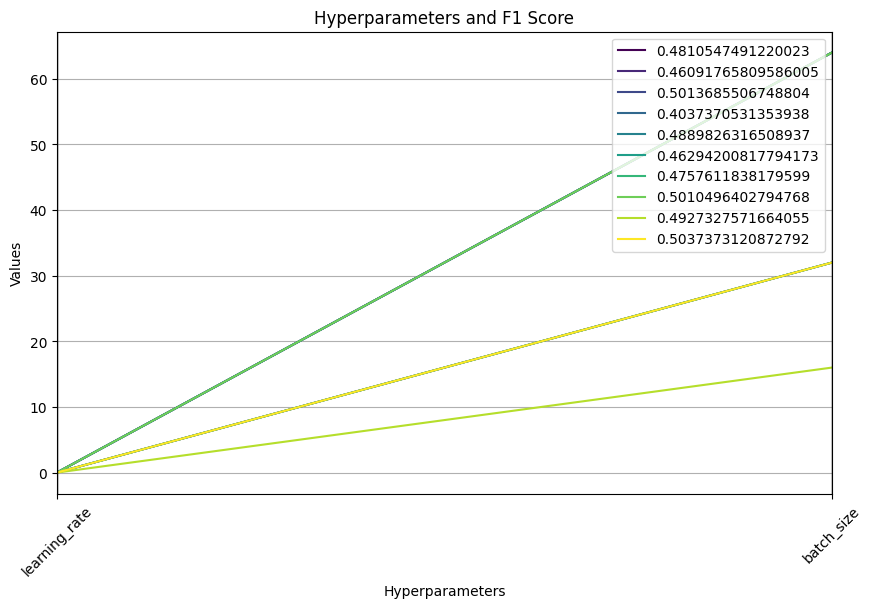

In [36]:
import pandas as pd
from pandas.plotting import parallel_coordinates

# Extract parameters and F1 scores into a DataFrame
data = []
for trial in study.trials:
    row = trial.params
    row["F1 Score"] = trial.value
    data.append(row)

df = pd.DataFrame(data)

# Plot Parallel Coordinates
plt.figure(figsize=(10, 6))
parallel_coordinates(df, class_column="F1 Score", colormap='viridis')
plt.title("Hyperparameters and F1 Score")
plt.xlabel("Hyperparameters")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


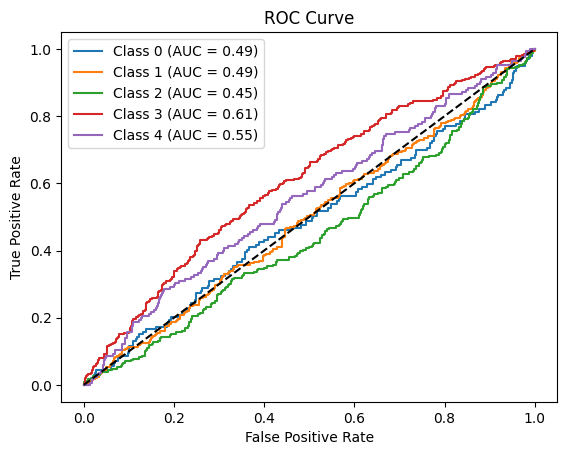

In [34]:
# Evaluate and Plot ROC Curve
predictions = final_trainer.predict(encoded_dataset["validation"])
probs = predictions.predictions
labels = predictions.label_ids

# Compute ROC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(probs.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(labels == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure()
for i in range(probs.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/2637468423.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torc

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.290800,1.151662,0.497729,0.531955,0.497729,0.432667
2,1.083000,1.139779,0.492280,0.485880,0.492280,0.471202
3,0.938100,1.106600,0.504995,0.509545,0.504995,0.496459
4,0.774100,1.177481,0.504087,0.502136,0.504087,0.499311
5,0.657400,1.327211,0.505904,0.504900,0.505904,0.499864
6,0.425700,1.502884,0.495005,0.493505,0.495005,0.488470
7,0.295600,1.625605,0.489555,0.489743,0.489555,0.484158
8,0.264400,1.821908,0.485014,0.482737,0.485014,0.483277
9,0.188800,2.010281,0.466848,0.466221,0.466848,0.464936
10,0.184700,2.089703,0.484105,0.482995,0.484105,0.479370


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Final Evaluation Results: {'eval_loss': 1.106600046157837, 'eval_accuracy': 0.5049954586739328, 'eval_precision': 0.5095450724233499, 'eval_recall': 0.5049954586739328, 'eval_f1': 0.4964587120921691, 'eval_runtime': 2.7483, 'eval_samples_per_second': 400.609, 'eval_steps_per_second': 3.275, 'epoch': 10.0}


ValueError: x and y must have same first dimension, but have shapes (13,) and (11,)

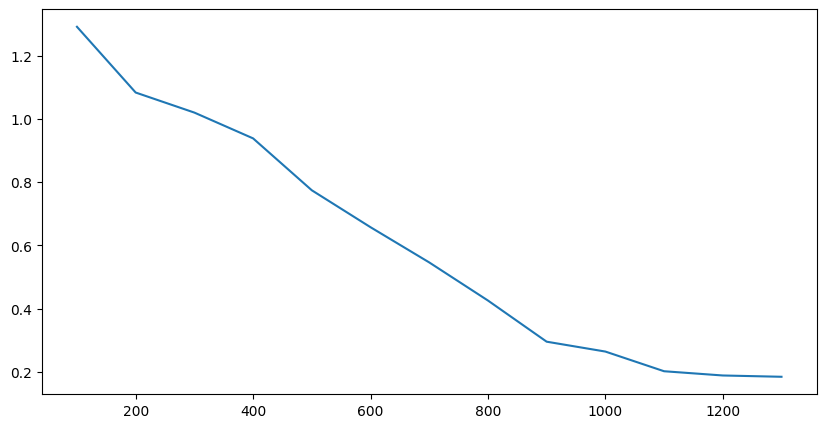

In [38]:
best_learning_rate = 2.3532960037330013e-05  # From tuning results
best_batch_size = 32  # From tuning results

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,  # Increase epochs to allow further training with best hyperparameters
    per_device_train_batch_size=best_batch_size,  # Best batch size
    per_device_eval_batch_size=best_batch_size * 2,
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",  # Save model after every epoch
    learning_rate=best_learning_rate,  # Best learning rate
    lr_scheduler_type="reduce_lr_on_plateau",  # Reduce LR when performance plateaus
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,  # Use mixed precision for faster training
    save_total_limit=2,  # Limit saved models to the 2 best checkpoints
    dataloader_num_workers=4,  # Efficient data loading
    report_to=None,  # Disable reporting to external systems
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],  # Training dataset
    eval_dataset=encoded_dataset["validation"],  # Validation dataset
    tokenizer=tokenizer,  # Tokenizer for preprocessing
    compute_metrics=compute_metrics,  # Metrics function for evaluation
)

# Train the Model
trainer.train()

# Evaluate the Model
results = trainer.evaluate()
print("Final Evaluation Results:", results)

# Plot Learning Rate and Metrics
metrics = trainer.state.log_history

# Extract relevant data
train_loss = [x["loss"] for x in metrics if "loss" in x and "step" in x]
eval_loss = [x["eval_loss"] for x in metrics if "eval_loss" in x]
eval_accuracy = [x["eval_accuracy"] for x in metrics if "eval_accuracy" in x]
steps = [x["step"] for x in metrics if "loss" in x]

# Plot Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps, eval_loss, label="Validation Loss", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
epochs = range(1, len(eval_accuracy) + 1)
plt.plot(epochs, eval_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Across Epochs")
plt.legend()
plt.show()


In [46]:
# Print the model's configuration
print(model.config)

AlbertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "

Testing on Large-v2-albertmodel

In [62]:
def preprocess_function(examples):
    tokenized_sentences = examples["text"]
    fixed_sentences = [
        fix_apostrophes_in_tokens(tokens) for tokens in tokenized_sentences
    ]
    sentences = [" ".join(tokens) for tokens in fixed_sentences]
    return tokenizer(sentences, padding="max_length", truncation=True, max_length=64)

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Load the ALBERT-Large Model
model = Amodel = AlbertForSequenceClassification.from_pretrained("albert-large-v2", num_labels=5)

# Compute Metrics Function
def compute_metrics(pred):
    predictions, labels = pred
    preds = predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [63]:
training_args = TrainingArguments(
    output_dir="./results_albert_large",
    num_train_epochs=10,  # You can adjust based on dataset size
    per_device_train_batch_size=16,  # Adjust batch size for large model
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2.3532960037330013e-05,  # Learning rate from previous tuning
    lr_scheduler_type="reduce_lr_on_plateau",  # Dynamically adjust LR
    load_best_model_at_end=True,
    logging_dir="./logs_albert_large",
    logging_steps=100,
    fp16=True,  # Mixed precision for efficiency
    save_total_limit=2,
    dataloader_num_workers=4,
    report_to=None,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate()
print("Evaluation Results for ALBERT-Large:", results)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_23/2514338083.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/pa

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.600400,1.584518,0.262489,0.068900,0.262489,0.109150
2,1.585500,1.589118,0.253406,0.064215,0.253406,0.102464
3,1.585800,1.574015,0.253406,0.064215,0.253406,0.102464
4,1.581200,1.572837,0.253406,0.064215,0.253406,0.102464
5,1.425600,1.574636,0.327884,0.190666,0.327884,0.206942
6,1.305900,1.300045,0.416894,0.481524,0.416894,0.369178
7,1.161500,1.393847,0.407811,0.422233,0.407811,0.398552
8,1.069100,1.376737,0.413261,0.411041,0.413261,0.386110
9,0.884800,1.481622,0.435967,0.437580,0.435967,0.429537
10,0.663400,1.674165,0.425068,0.435721,0.425068,0.421047


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with to

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Evaluation Results for ALBERT-Large: {'eval_loss': 1.3000448942184448, 'eval_accuracy': 0.41689373297002724, 'eval_precision': 0.4815238192184514, 'eval_recall': 0.41689373297002724, 'eval_f1': 0.3691776574803884, 'eval_runtime': 8.5194, 'eval_samples_per_second': 129.234, 'eval_steps_per_second': 2.113, 'epoch': 10.0}


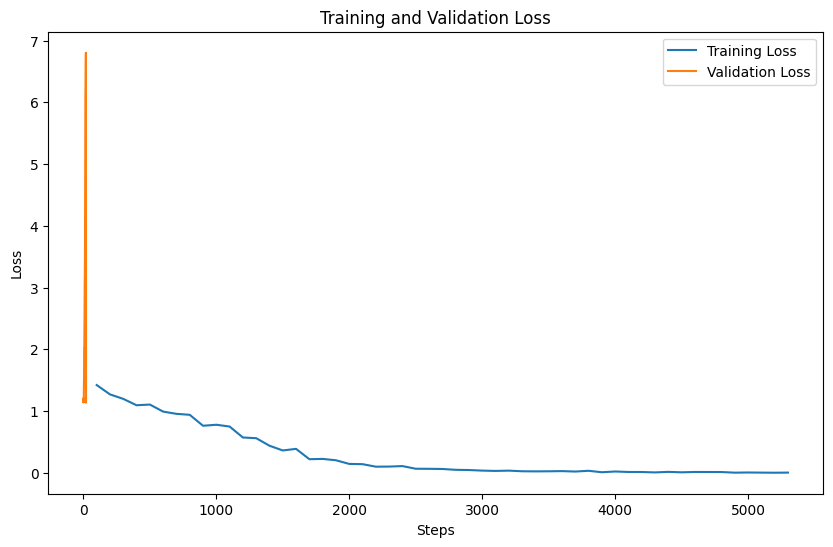

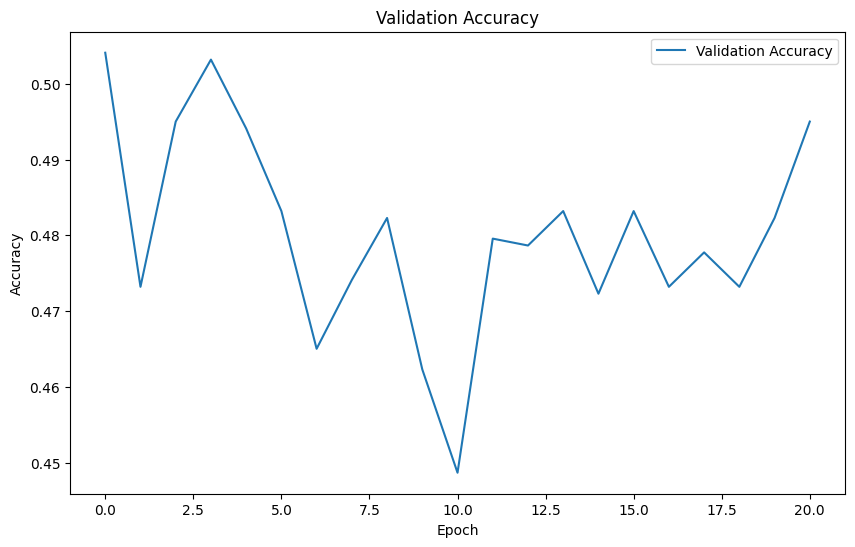

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Extract Metrics
metrics = trainer.state.log_history
train_loss = [x["loss"] for x in metrics if "loss" in x and "step" in x]
eval_loss = [x["eval_loss"] for x in metrics if "eval_loss" in x]
eval_accuracy = [x["eval_accuracy"] for x in metrics if "eval_accuracy" in x]
steps = [x["step"] for x in metrics if "loss" in x]

# Plot Training and Evaluation Loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(range(len(eval_loss)), eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(len(eval_accuracy)), eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


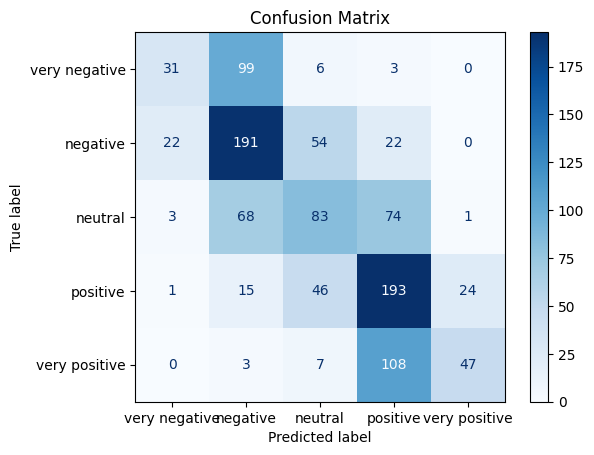

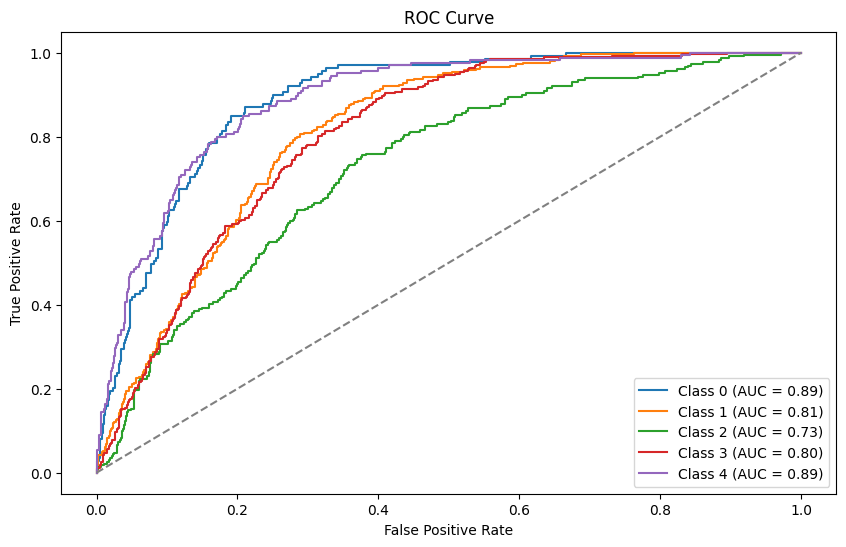

In [22]:
from sklearn.metrics import confusion_matrix

eval_preds = trainer.predict(encoded_dataset["validation"])
preds = eval_preds.predictions.argmax(axis=1)
labels = eval_preds.label_ids
cm = confusion_matrix(labels, preds)

class_names = ["very negative", "negative", "neutral", "positive", "very positive"]
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
from sklearn.preprocessing import label_binarize

binary_labels = label_binarize(labels, classes=list(range(5)))
pred_probs = torch.nn.functional.softmax(torch.tensor(eval_preds.predictions), dim=1).numpy()

fpr = {}
tpr = {}
roc_auc = {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
